# Set up

In [1]:
#load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Function to plot with error bars
def plot_with_errorbars(data, color, **kwargs):
    ax = plt.gca()
    for name, group in data.groupby('study_group'):
        group = group.sort_values('ses')
        means = group.groupby('ses')['score'].mean()
        errors = group.groupby('ses')['score'].sem()  # Standard error of the mean
        sessions = means.index
        ax.errorbar(sessions, means, yerr=errors, fmt='o-', linewidth=3, elinewidth=3, label=name, color=color)

In [3]:
#set paths
current_directory = os.getcwd()
base_dir = f'{os.path.dirname(current_directory)}/'
data_dir = f'{base_dir}Source_Data/'
fig_dir = f'{base_dir}/figures/'


### Figure 3a

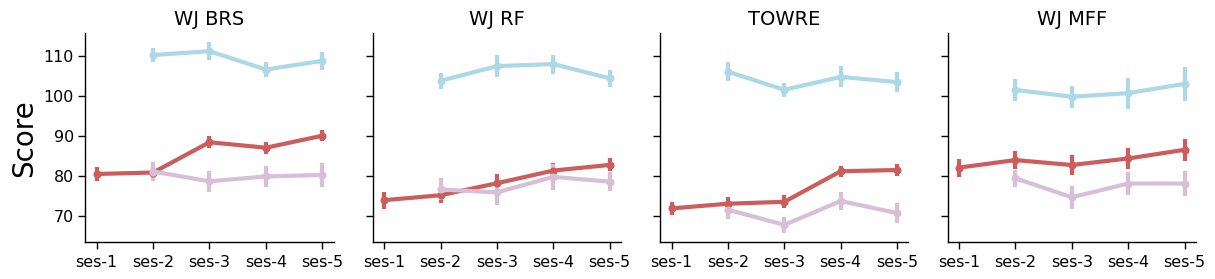

In [7]:
save_fig=False

# read in data
plot_df = pd.read_csv(f'{data_dir}fig_3a.csv')

# Custom titles for each measure
titles = {
    'wj_brs': 'WJ BRS',
    'wj_rf': 'WJ RF',
    'twre_index': 'TOWRE',
    'wj_mff_ss': 'WJ MFF'
}

# Custom color palette
palette = ['#CD5C5C','#D8BFD8','#ADD8E6']

# Custom legend labels
legend_labels = {
    'intervention': 'Intervention',
    'typ_control': 'Typical Ctrl',
    'dys_control': 'Dyslexic Ctrl'
}

sns.set_theme(context='paper', style=None, font_scale=1.3)

# Create a FacetGrid
g = sns.FacetGrid(plot_df, col='measure', hue='study_group', hue_order=['intervention','dys_control','typ_control'], 
                  sharey=True, palette=palette)

# Map the custom plotting function to the grid
g.map_dataframe(plot_with_errorbars)

# Add titles and adjust layout
g.set_titles(col_template='{col_name}')
for ax, title in zip(g.axes.flatten(), g.col_names):
    ax.set_title(titles[title], size=14)

g.set_axis_labels('', 'Score',size=20)

# Adjust subplot spacing for better readability
plt.subplots_adjust(top=0.85)

if save_fig:
    plt.savefig(f'{fig_dir}fig_3a.svg', bbox_inches="tight", transparent=True, dpi=400)

# Show the plot
plt.show()

### Table S13

In [4]:
# load data
df = pd.read_csv(f'{data_dir}tbl_s13.csv')

# Assuming scores_df is already defined
assessments = ['wj_brs', 'wj_rf', 'twre_index', 'wj_mff_ss']
groups = ['intervention', 'dys_control', 'typ_control']

# Initialize a list to hold results for the final DataFrame
results = []

# Counts for participants categorized by their traits and state variability
counts = {assessment: {group: {
            "High Trait High State Variability": set(),
            "High Trait Low State Variability": set(),
            "Low Trait High State Variability": set(),
            "Low Trait Low State Variability": set()
          } for group in groups} for assessment in assessments}

for assessment in assessments:
    for group in groups:
        # Filter the DataFrame for the current group
        group_scores = df.query('study_group == @group')
        
        # Calculate average and std for state scores
        avg_state = np.nanmean(group_scores[f'{assessment}_state'])
        std_state = np.nanstd(group_scores[f'{assessment}_state'])
        
        # Calculate average and std for trait scores (unique participants)
        traits = group_scores[['sub', f'{assessment}_trait']].drop_duplicates()
        avg_trait = np.nanmean(traits[f'{assessment}_trait'])
        std_trait = np.nanstd(traits[f'{assessment}_trait'])
        
        # Get the individual state standard deviations for all participants
        state_sds = []
        for sub_id in group_scores['sub'].unique():
            participant_scores = group_scores[group_scores['sub'] == sub_id][f'{assessment}_state']
            participant_sd = np.nanstd(participant_scores)  # Calculate SD for the participant
            state_sds.append(np.abs(participant_sd))  # Append absolute value of SD

        # Calculate the median of absolute state SDs
        median_state_sd = np.nanmedian(state_sds)

        # Define high/low trait conditions
        high_trait_condition = group_scores[f'{assessment}_trait'] > avg_trait
        low_trait_condition = group_scores[f'{assessment}_trait'] <= avg_trait

        # Determine state variability for each participant
        state_variability = {}
        for sub_id in group_scores['sub'].unique():
            participant_scores = group_scores[group_scores['sub'] == sub_id][f'{assessment}_state']
            participant_sd = np.nanstd(participant_scores)
            state_variability[sub_id] = abs(participant_sd) > median_state_sd  # True if high variability

        # Count unique participants based on conditions
        if high_trait_condition.any():
            high_trait_scores = group_scores[high_trait_condition]
            for sub_id in high_trait_scores['sub']:
                if state_variability[sub_id]:  # High Variability
                    counts[assessment][group]["High Trait High State Variability"].add(sub_id)
                else:  # Low Variability
                    counts[assessment][group]["High Trait Low State Variability"].add(sub_id)

        if low_trait_condition.any():
            low_trait_scores = group_scores[low_trait_condition]
            for sub_id in low_trait_scores['sub']:
                if state_variability[sub_id]:  # High Variability
                    counts[assessment][group]["Low Trait High State Variability"].add(sub_id)
                else:  # Low Variability
                    counts[assessment][group]["Low Trait Low State Variability"].add(sub_id)

        # Append results to the final DataFrame
        results.append({
            'assessment': assessment,
            'study_group': group,
            'average_trait': avg_trait,
            'trait_std': std_trait,
            'state_std': std_state,
            'high_trait_high_state_count': len(counts[assessment][group]["High Trait High State Variability"]),
            'high_trait_low_state_count': len(counts[assessment][group]["High Trait Low State Variability"]),
            'low_trait_high_state_count': len(counts[assessment][group]["Low Trait High State Variability"]),
            'low_trait_low_state_count': len(counts[assessment][group]["Low Trait Low State Variability"]),
        })

# Create the final DataFrame
final_df = pd.DataFrame(results)

# Generate a category column for better representation
final_df['category'] = final_df['assessment'] + ' ' + final_df['study_group']
final_df = final_df[['category', 'average_trait', 'trait_std', 'state_std', 
                     'high_trait_high_state_count', 'high_trait_low_state_count', 
                     'low_trait_high_state_count', 'low_trait_low_state_count']]

# Print the final DataFrame
final_df

/Users/jamiel12/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,category,average_trait,trait_std,state_std,high_trait_high_state_count,high_trait_low_state_count,low_trait_high_state_count,low_trait_low_state_count
0,wj_brs intervention,84.910985,9.183328,6.046928,8,14,14,8
1,wj_brs dys_control,79.285088,10.026402,4.656309,5,3,4,7
2,wj_brs typ_control,109.496528,8.524185,3.804332,6,6,6,6
3,wj_rf intervention,77.567045,12.599594,5.149558,9,15,13,7
4,wj_rf dys_control,77.171053,11.658251,3.270716,3,7,6,3
5,wj_rf typ_control,107.351449,10.025751,4.408451,5,7,6,5
6,twre_index intervention,75.871591,9.851202,5.235519,10,13,12,9
7,twre_index dys_control,70.210526,8.455092,3.562801,4,6,5,4
8,twre_index typ_control,103.062500,10.464619,4.200794,6,5,6,7
9,wj_mff_ss intervention,83.388636,15.409563,4.860978,14,8,8,14
